<a href="https://colab.research.google.com/github/sid-chaubs/data-mining-assignment-1/blob/main/DMT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [322]:
!git clone https://github.com/sid-chaubs/data-mining-assignment-1.git
%cd data-mining-assignment-1/

Cloning into 'data-mining-assignment-1'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 69 (delta 33), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (69/69), done.
/content/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1/data-mining-assignment-1


Original data shape:  (313, 17)
            Timestamp           What programme are you in?  \
0  3/16/2021 14:37:20  Master Tax Law - Tax and Technology   
1  3/24/2021 17:28:48                                   AI   
2  3/25/2021 12:31:29                                  DMT   
3  3/25/2021 15:56:30                                   CS   
4  3/25/2021 17:41:04                                   AI   

  Have you taken a course on machine learning?  \
0                                          yes   
1                                           no   
2                                           no   
3                                           no   
4                                          yes   

  Have you taken a course on information retrieval?  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 1   
4                  

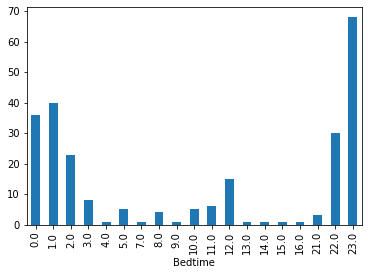

In [323]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import regex
from sklearn import tree, model_selection, preprocessing, ensemble, neighbors
from scipy import stats

pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)
#read in data
data = pd.read_csv('ODI-2021.csv')
print('Original data shape: ', data.shape)
print(data.head())
#sanitize programmes
data['Programme'] = data['What programme are you in?'].apply(lambda s: regex.sub(r'(masters|master|msc|m\s|\sat.*|\suva|\(uva\)|\\|\svu)', '', s.lower()))


#sanitize birthdays
data['Birthday'] = pd.to_datetime(data['When is your birthday (date)?'], errors='coerce')

#normalize course participation data
data['DB course taken'] = data['Have you taken a course on databases?'] == 'ja'
data['Information retrieval course taken'] = data['Have you taken a course on information retrieval?'] == '1'
data['ML course taken'] = data['Have you taken a course on machine learning?'] == 'yes'
data['Statistics course taken'] = data['Have you taken a course on statistics?'] == 'mu'

#sanitize/convert other columns
data['Number of neighbors'] = pd.to_numeric(data['Number of neighbors sitting around you?'], errors='coerce')
data['Stood up'] = data['Did you stand up?'] == 'yes'

data['Stress level'] = pd.to_numeric(data['What is your stress level (0-100)?'], errors='coerce')
data['Stress level'] = list(map(lambda d: min(100, d), data['Stress level']))
data['Competition reward'] = pd.to_numeric(data['You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? '], errors='coerce')
data['Random number'] = pd.to_numeric(data['Give a random number'], errors='coerce')

match_single_hours = r'(^[0-9]+)\s*(am|pm|$)$'
match_dots = r'([0-9]+)\.([0-9]+)'
#sanitize bedtime
data['Bedtime'] = pd.to_datetime(list(map(lambda dt: regex.sub(match_single_hours, r'\1:00 \2', dt), 
                                          map(lambda dt: regex.sub(match_dots, r'\1:\2', dt), data['Time you went to be Yesterday']))), 
                                 errors='coerce')
data['Bedtime'].groupby(data['Bedtime'].dt.hour).count().plot(kind='bar')

In [324]:
#different regexs for matching possible observed programme names 
match_superfluous = r'(masters|master|msc|m\s|\sat.*|\suva|\(uva\)|\\|\svu)'
match_cs = r'.*(^cs|\scs|computer science|computational science).*'
match_ai = r'.*(^ai|\sai|artificial intelli).*'
match_bio = r'.*(bioinformatics and s.*|bioinformatics & systems biology).*'
match_qrm = r'.*(qrm|quantative risk management|quantitative risk management).*'
match_ba = r'.*(^ba|\sba|business analytics)'
match_eor = r'.*(^eor|^e&or|^or|econometrics and op.*|econometrics & op.*)'
match_eds = r'.*(^eds|econometrics and data science.*)'
match_ec = r'.*(econometrics)'
match_ft = r'.*(^ft|fintech|finance & technology|finance and technology)'

#zip the matching regexes and corresponding substitutions together
regsubs = zip([match_superfluous, match_cs, match_ai, match_bio, match_qrm, match_ba, match_eor, match_eds, match_ec, match_ft],
              ['', 'Computer Science', 'Artificial Intelligence', 'Bioinformatics and Systems Biology', 'Quantitative Risk Management',
               'Business Analytics', 'Econometrics and Operations Research', 'Econometrics and Data Science', 'Econometrics', 'Finance and Technology'])

def regex_to_sub(re, substr):
  '''Helper function for creating an anonymous substitution function with regex.'''
  return lambda s: regex.sub(re, substr, s)

#convert to lowercase, substitute course names, remove leading/trailing spaces and capitalize everything left
regfuncs = [lambda s: s.lower()]\
  + [regex_to_sub(re, s) for re, s in regsubs]\
  + [str.strip, lambda s: s[0].upper() + s[1:]] 

def chain_sanitize(data, funcs):
  '''Apply a list of functions to data in sequence and return the result.'''
  res = data
  for f in funcs:
    res = res.apply(f)
  return res

data['Programme'] = chain_sanitize(data['What programme are you in?'], regfuncs)
list(data['Programme'])

['Tax law - tax and technology',
 'Artificial Intelligence',
 'Dmt',
 'Computer Science',
 'Artificial Intelligence',
 'Systesecurity',
 'Quantitative Risk Management',
 'Computer Science',
 'Artificial Intelligence',
 'Artificial Intelligence',
 'Computer Science',
 'Artificial Intelligence',
 'Big data engineering',
 'Bioinformatics and Systems Biology',
 'Human language technology',
 'Artificial Intelligence',
 'Computer Science',
 'Artificial Intelligence',
 'Quantitative Risk Management',
 'Business Analytics',
 'Artificial Intelligence',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Artificial Intelligence',
 'Linguistics: text mining',
 'Bioinformatics and Systems Biology',
 'Business Analytics',
 'Bioinformatics and Systems Biology',
 'Computer Science',
 'Python',
 'Econometrics and Operations Research',
 'Computer Science',
 'Computer Science',
 'Computer Science',
 'Rma human language technology',
 'Human language technology (research 

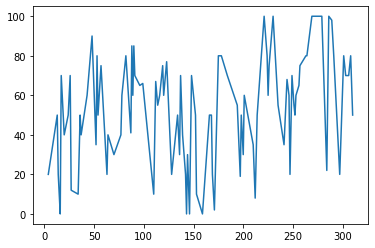

In [325]:
data.loc[(data['What is your gender?'] == 'female')]['Stress level'].plot()

In [326]:
gendermeans = data.groupby(['What is your gender?']).mean()

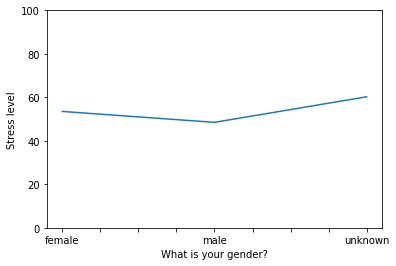

In [327]:
gendermeans['Stress level'].plot(ylabel='Stress level', ylim=(0,100))

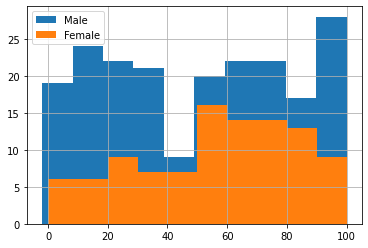

In [328]:
data.loc[data['What is your gender?']=='male']['Stress level'].hist()
data.loc[data['What is your gender?']=='female']['Stress level'].hist()
plt.legend(['Male', 'Female'])

Overall gender composition of the course:

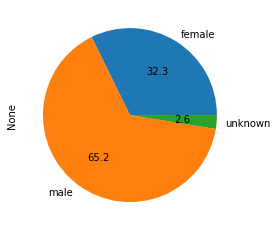

In [329]:
gender_counts = data.groupby(['What is your gender?']).size()
gender_counts.plot.pie(autopct='%.1f')

Most popular programmes amongst course-takers:

In [330]:
most_popular_progs = data.groupby(['Programme']).size().nlargest(4)
print('Programme counts:\n', most_popular_progs)
print('Most popular programmes account for {0:.2f}% of all represented programmes'
  .format(100 * most_popular_progs.sum()/data.shape[0]))

Programme counts:
 Programme
Artificial Intelligence               87
Computer Science                      56
Business Analytics                    35
Bioinformatics and Systems Biology    22
dtype: int64
Most popular programmes account for 63.90% of all represented programmes


In [331]:
gender_programmes = data.groupby(['What is your gender?', 'Programme']).size()

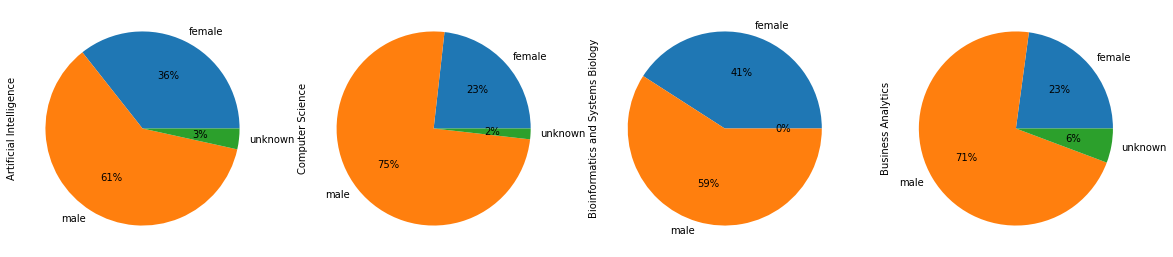

In [332]:
gp_unstacked = gender_programmes.unstack(fill_value=0)
programmes = ['Artificial Intelligence', 'Computer Science', 'Bioinformatics and Systems Biology', 'Business Analytics']
fig, axes = plt.subplots(nrows=1, ncols=len(programmes), figsize=(20,5))

#create a few pie charts for select most popular programmes to get an idea of gender distribution
for i, programme in enumerate(programmes):
  gp_unstacked[programme].plot.pie(autopct='%1.f%%', ax=axes[i])

Note that this doesn't necessarily represent the distributions of genders in these courses as it is possible that we're dealing with a biased sample of participants who took this course. (In other words, the distribution of genders in these programmes could be even, but a majority of males from them took Data Mining as a course)

In [333]:
#get the total number of participants by gender in most popular programmes
totals_in_popular = gp_unstacked[programmes].sum(axis=1).values
others_count = gender_counts.values - totals_in_popular
stats.chi2_contingency(pd.DataFrame.from_records([totals_in_popular, others_count]))

(1.1133843737705376,
 0.5731016451083633,
 2,
 array([[ 64.53674121, 130.3514377 ,   5.11182109],
        [ 36.46325879,  73.6485623 ,   2.88817891]]))

With a p-value of >0.57 we see that there is no significant effect of gender on studying one of the four most popular programmes for this course vs the others. We can also ask whether there is a relationship between gender and any specific programme in the top four:

In [334]:
print(stats.chi2_contingency(gp_unstacked[programmes]))
print('p-value for chi-squared contingency test of most popular programmes for this course: ',
      stats.chi2_contingency(gp_unstacked[programmes])[1])

(6.356109866408365, 0.38450255563355384, 6, array([[26.535, 17.08 ,  6.71 , 10.675],
       [57.855, 37.24 , 14.63 , 23.275],
       [ 2.61 ,  1.68 ,  0.66 ,  1.05 ]]))
p-value for chi-squared contingency test of most popular programmes for this course:  0.38450255563355384


Thus, among the four most popular programmes, even though there is an imbalance between the amount of male vs female programme candidates, there is no significant effect of gender vs choosing one of the most popular programmes, nor is there a significant gender effect within those programmes.

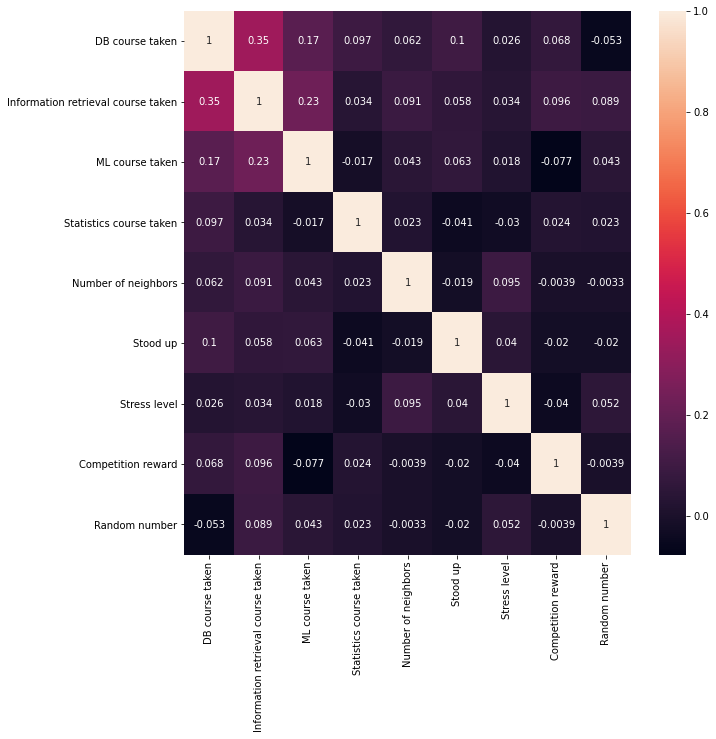

In [335]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, ax=ax)

In [336]:
chocolate_answer_coded = pd.get_dummies(data['Chocolate makes you.....'])
tree_data = pd.concat([chocolate_answer_coded, data['Stress level']], axis=1)
print(tree_data.shape)
tree_data.head()

(313, 6)


,I have no idea what you are talking about,fat,neither,slim,unknown,Stress level
0,0,0,1,0,0,85.0
1,1,0,0,0,0,0.0
2,0,1,0,0,0,40.0
3,1,0,0,0,0,42.0
4,0,0,1,0,0,20.0


In [337]:
train_cs, test_cs, train_g, test_g = model_selection.train_test_split(tree_data, data['What is your gender?'], test_size=0.33)
print(train_cs.shape, test_cs.shape, train_g.shape, test_g.shape)

(209, 6) (104, 6) (209,) (104,)


In [338]:
train_cs[:3], train_g[:3]

(     I have no idea what you are talking about  fat  neither  slim  unknown  \
 33                                           0    0        1     0        0   
 142                                          0    0        0     0        1   
 115                                          0    1        0     0        0   
 
      Stress level  
 33            5.0  
 142          20.0  
 115          60.0  , 33       male
 142    female
 115      male
 Name: What is your gender?, dtype: object)

In [339]:
data.iloc[train_cs[:3].index]

,Timestamp,What programme are you in?,Have you taken a course on machine learning?,Have you taken a course on information retrieval?,Have you taken a course on statistics?,Have you taken a course on databases?,What is your gender?,Chocolate makes you.....,When is your birthday (date)?,Number of neighbors sitting around you?,Did you stand up?,What is your stress level (0-100)?,"You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then?",Give a random number,Time you went to be Yesterday,What makes a good day for you (1)?,What makes a good day for you (2)?,Programme,Birthday,DB course taken,Information retrieval course taken,ML course taken,Statistics course taken,Number of neighbors,Stood up,Stress level,Competition reward,Random number,Bedtime
33,3/29/2021 11:19:21,Computational science,no,0,mu,ja,male,neither,11-11-1997,0:(,no,5,70,11,12:30,Sunshine,Friends,Computer Science,1997-11-11,True,False,False,True,NaN,False,5.0,70.0,11.0,2021-04-16 12:30:00
142,3/30/2021 11:11:47,Msc AI,no,0,mu,ja,female,unknown,15-05,1,no,20,10,5,23:00,Sun,Smile,Artificial Intelligence,NaT,True,False,False,True,1.0,False,20.0,10.0,5.0,2021-04-16 23:00:00
115,3/30/2021 9:40:31,CS,no,1,mu,ja,male,fat,-,0,no,60,65,8,23:50,Free time,Being outside,Computer Science,NaT,True,True,False,True,0.0,False,60.0,65.0,8.0,2021-04-16 23:50:00


In [340]:
dect_chocstress = tree.DecisionTreeClassifier()

dect_chocstress = dect_chocstress.fit(train_cs, train_g)

print('one time test score: ', dect_chocstress.score(test_cs, test_g))

print('cross-validation scores: ', model_selection.cross_validate(dect_chocstress, test_cs, test_g, scoring='accuracy'))
scores = model_selection.cross_validate(dect_chocstress, test_cs, test_g, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print('f1:', np.mean(scores['test_f1_weighted']))
print('precision:', np.mean(scores['test_precision_weighted']))
print('recall:', np.mean(scores['test_recall_weighted']))

one time test score:  0.5
cross-validation scores:  {'fit_time': array([0.00381565, 0.00336695, 0.00337839, 0.00220847, 0.00192118]), 'score_time': array([0.00159001, 0.00142622, 0.00123382, 0.00113988, 0.0010016 ]), 'test_score': array([0.42857143, 0.47619048, 0.57142857, 0.47619048, 0.3       ])}
f1: 0.4457247979283247
precision: 0.4656689342403628
recall: 0.45095238095238094


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

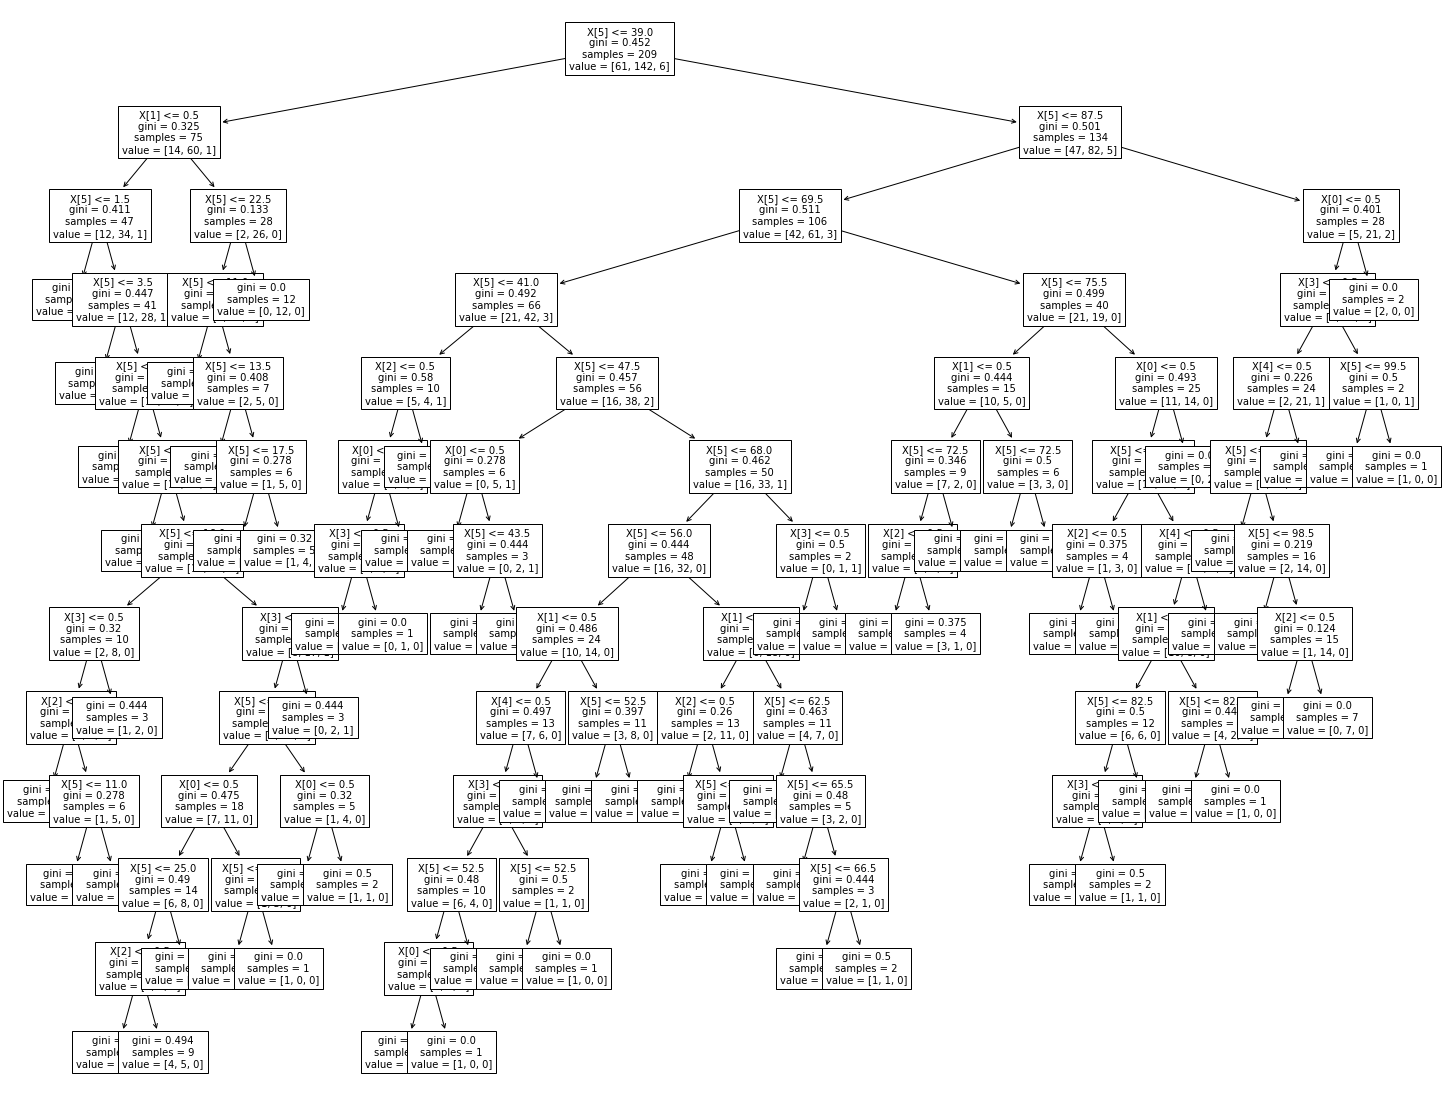

In [341]:
plt.figure(figsize=(25, 20))
tree.plot_tree(dect_chocstress, fontsize=10);

In [342]:
knn_data = pd.concat([tree_data, data['Statistics course taken'], data['DB course taken']], axis=1)
train_csn, test_csn, train_g, test_g = model_selection.train_test_split(knn_data, data['What is your gender?'])

In [343]:
neigh = neighbors.KNeighborsClassifier(15)
neigh = neigh.fit(train_csn, train_g)
knnscores = model_selection.cross_val_score(neigh, test_csn, test_g)
print(knnscores, np.mean(knnscores))
print(model_selection.cross_validate(neigh, test_csn, test_g))

[0.5625     0.625      0.5        0.5625     0.53333333] 0.5566666666666666
{'fit_time': array([0.00272274, 0.00248265, 0.00266838, 0.00244999, 0.00389385]), 'score_time': array([0.00317121, 0.00399661, 0.00288796, 0.00281286, 0.00300074]), 'test_score': array([0.5625    , 0.625     , 0.5       , 0.5625    , 0.53333333])}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [344]:
scores = model_selection.cross_validate(neigh, test_csn, test_g, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print(np.mean(scores['test_f1_weighted']))
print(np.mean(scores['test_precision_weighted']))
print(np.mean(scores['test_recall_weighted']))

0.49039901523597174
0.4705459124209124
0.5566666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sample

In [352]:
data.groupby('What is your gender?').size()

What is your gender?
female     101
male       204
unknown      8
dtype: int64

#Task 2

In [345]:
titanic_train = pd.read_csv('titanic_train.csv')
titanic_test = pd.read_csv('titanic_test.csv')

In [346]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


Age mu: 29.69911764705882, sigma: 14.516321150817316
Chi 2 params:  53.496425217328905 -45.3730545635469 1.4033117534731576


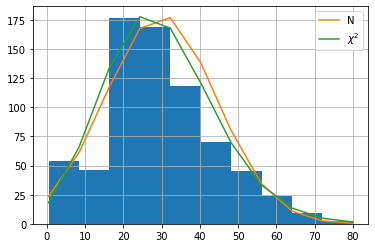

In [347]:
#plotting the histogram of ages and a fitted normal PDF
_, bins, _ = plt.hist(titanic_train['Age']) #store x coords of bins for later PDF plotting
plt.grid()
t_age_mu, t_age_sigma = stats.norm.fit(titanic_train['Age'].dropna())
chi2_params = stats.chi2.fit(titanic_train['Age'].dropna())
#maxh/maxn is a scaling factor that makes it possible to compare the two graphs
maxn = max(stats.norm.pdf(bins, t_age_mu, t_age_sigma))
maxc = max(stats.chi2.pdf(bins, *chi2_params))
maxh = max(titanic_train['Age'].value_counts(bins=10))
plt.plot(bins, (maxh/maxn)* stats.norm.pdf(bins, t_age_mu, t_age_sigma))
plt.plot(bins, (maxh/maxc)* stats.chi2.pdf(bins, 53.5, -45.37, 1.4))
plt.legend(['N', '$\chi^2$'])
print('Age mu: {0}, sigma: {1}'.format(t_age_mu, t_age_sigma))
print('Chi 2 params: ', *chi2_params)

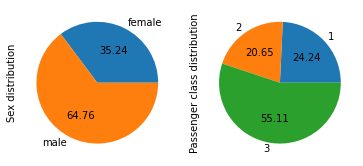

In [348]:
fig, axes = plt.subplots(nrows=1, ncols=2)
titanic_train.groupby('Sex').size().plot.pie(ax=axes[0], autopct='%.2f', ylabel='Sex distribution')
titanic_train.groupby('Pclass').size().plot.pie(ax=axes[1], autopct='%.2f', ylabel='Passenger class distribution')

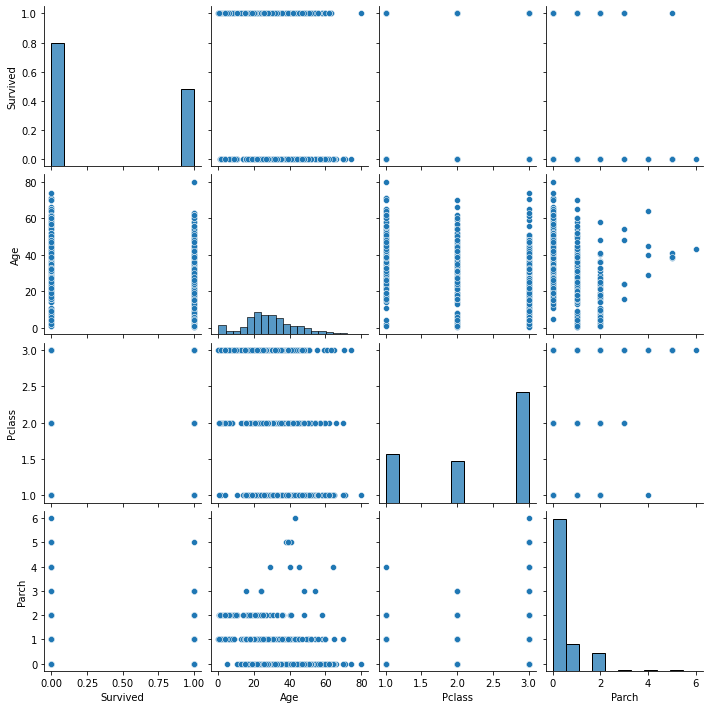

In [349]:
sns.pairplot(titanic_train[['Survived', 'Sex', 'Age', 'Pclass', 'Parch']])